# PINN for Navier-Stokes Equations

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Brief Overview of Navier-Stokes Equations

The Navier-Stokes equations are a set of partial differential equations that describe the motion of fluid substances. These equations mathematically express momentum balance for Newtonian fluids and make use of conservation of mass.

Consider an incompressible Newtonian fluid. The two-dimensional Navier-Stokes equations governing the motion of such a fluid are given by:

$$
\frac{\partial u}{\partial t} + \lambda_1 \left( u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} \right) = -\frac{\partial p}{\partial x} + \lambda_2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

$$
\frac{\partial v}{\partial t} + \lambda_1 \left( u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} \right) = -\frac{\partial p}{\partial y} + \lambda_2 \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
$$

where:

- $ u(x, y, t) $ and $ v(x, y, t) $ are the *velocity components* of the fluid in the $ x $- and $ y $-directions, respectively, at a given time $ t $.

- $ p(x, y, t) $ is the *pressure* field of the fluid at a given point in space and time.

- $ \frac{\partial u}{\partial t} $ and $ \frac{\partial v}{\partial t} $ represent the *time derivatives of the velocity components*, $ u $ and $ v $, describing how the velocity evolves over time.

- $ \frac{\partial u}{\partial x} $, $ \frac{\partial u}{\partial y} $, $ \frac{\partial v}{\partial x} $, and $ \frac{\partial v}{\partial y} $ are the *spatial derivatives of the velocity components*, representing how the velocity changes in space.

- $ \frac{\partial p}{\partial x} $ and $ \frac{\partial p}{\partial y} $ are the *pressure gradients* in the $ x $- and $ y $-directions, respectively, driving fluid motion.

- $ \frac{\partial^2 u}{\partial x^2} $, $ \frac{\partial^2 u}{\partial y^2} $, $ \frac{\partial^2 v}{\partial x^2} $, and $ \frac{\partial^2 v}{\partial y^2} $ are the *second-order spatial derivatives of the velocity components*, representing the diffusion (or dissipation) of momentum due to viscosity.

- $ \lambda_1 $ and $ \lambda_2 $ are constants.

Since the fluid is assumed to be incompressible, the continuity equation must be satisfied:

$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$

## Defining the Model Architecture

Below, we define the architecture of a model.

In [3]:
class Model(nn.Module):
    def __init__(self, hidden_channels:int) -> None:
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(3, hidden_channels),
            nn.Tanh(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.Tanh(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.Tanh(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.Tanh(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.Tanh(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.Tanh(),
            nn.Linear(hidden_channels, 3)
        )

    
    def forward(self, x:torch.Tensor, y:torch.Tensor, t:torch.Tensor) -> torch.Tensor:
        inputs = torch.cat([x, y, t], dim=-1)
        output = self.network(inputs)
        u, v, p = output[:, 0:1], output[:, 1:2], output[:, 2:3]
        return u, v, p

## Infering a System's Parameters

From the Navier Stokes Equations, we can derive two functions, $f$ and $g$ such that:

$$
f(x, y, t) = \frac{\partial u}{\partial t} + \lambda_1 \left( u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} \right) + \frac{\partial p}{\partial x} - \lambda_2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

$$
g(x, y, t) = \frac{\partial v}{\partial t} + \lambda_1 \left( u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} \right) + \frac{\partial p}{\partial y} - \lambda_2 \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
$$

For this task, we want to determine the values of $\lambda_1$ and $\lambda_2$. The loss function for this can be represented by the following:

$$
\mathcal{L}_{total} = \mathcal{L}_{physics} + \mathcal{L}_{data}
$$

where:
- **Physics Loss**
$$
\mathcal{L}_{physics} = \frac{1}{N} \sum_{i=1}^N \left(f(x_i, y_i, t_i)^2 + g(x_i, y_i, t_i)^2 \right)
$$

- **Data Loss**
$$
\mathcal{L}_{data} = \frac{1}{N} \sum^{N}_{i} \left((u(t_i, x_i, y_i) - u_i)^2 + (v(t_i, x_i, y_i) - v_i)^2 \right)
$$

We will be importing the dataset used in the [original paper](https://www.sciencedirect.com/science/article/abs/pii/S0021999118307125). In that dataset, the known values of $\lambda_1$ and $\lambda_2$ are 1 and 0.01 respectively. Similar to the paper, we will only be training on 1% of the original data.

In [4]:
import scipy

data = scipy.io.loadmat('data/cylinder_nektar_wake.mat')

U_star = data['U_star']
P_star = data['p_star']
t_star = data['t']
X_star = data['X_star']

N = X_star.shape[0]
T = t_star.shape[0]

x = np.tile(X_star[:,0:1], (1, T)).flatten()[:,None]
y = np.tile(X_star[:,1:2], (1, T)).flatten()[:,None]
t = np.tile(t_star, (1, N)).T.flatten()[:,None]
u = U_star[:,0,:].flatten()[:,None]
v = U_star[:,1,:].flatten()[:,None]
p = P_star.flatten()[:,None]

In [5]:
idx = np.random.choice(N*T, 5000, replace=False)

x = torch.tensor(x[idx,:], dtype=torch.float32).requires_grad_(True).to(device)
y = torch.tensor(y[idx,:], dtype=torch.float32).requires_grad_(True).to(device)
t = torch.tensor(t[idx,:], dtype=torch.float32).requires_grad_(True).to(device)
u = torch.tensor(u[idx,:], dtype=torch.float32).requires_grad_(True).to(device)
v = torch.tensor(v[idx,:], dtype=torch.float32).requires_grad_(True).to(device)

In [6]:
pinn = Model(32).to(device)

lambda1 = torch.nn.Parameter(torch.zeros(1, requires_grad=True, device=device))
lambda2 = torch.nn.Parameter(torch.zeros(1, requires_grad=True, device=device))

optimizer = optim.Adam(list(pinn.parameters()) + [lambda1, lambda2], lr=1e-3)

In [7]:
num_training_steps = 20000

lambda1_values = []
lambda2_values = []

for training_step in range(num_training_steps):
    optimizer.zero_grad()

    u_pred, v_pred, p_pred = pinn(x, y, t)

    u_x = torch.autograd.grad(u_pred, x, torch.ones_like(u_pred), create_graph=True)[0]
    u_y = torch.autograd.grad(u_pred, y, torch.ones_like(u_pred), create_graph=True)[0]
    u_t = torch.autograd.grad(u_pred, t, torch.ones_like(u_pred), create_graph=True)[0]

    v_x = torch.autograd.grad(v_pred, x, torch.ones_like(v_pred), create_graph=True)[0]
    v_y = torch.autograd.grad(v_pred, y, torch.ones_like(v_pred), create_graph=True)[0]
    v_t = torch.autograd.grad(v_pred, t, torch.ones_like(v_pred), create_graph=True)[0]

    p_x = torch.autograd.grad(p_pred, x, torch.ones_like(p_pred), create_graph=True)[0]
    p_y = torch.autograd.grad(p_pred, y, torch.ones_like(p_pred), create_graph=True)[0]

    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]

    v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, torch.ones_like(v_y), create_graph=True)[0]

    # Data Loss
    mse_data = torch.mean((u - u_pred)**2 + (v - v_pred)**2)

    # Physics Loss
    f = u_t + lambda1 * (u_pred * u_x + v_pred * u_y) + p_x - lambda2 * (u_xx + u_yy)
    g = v_t + lambda1 * (u_pred * v_x + v_pred * v_y) + p_y - lambda2 * (v_xx + v_yy)

    mse_physics = torch.mean(f**2 + g**2)
    
    # Total Loss
    loss = mse_data + mse_physics

    loss.backward()
    optimizer.step()

    lambda1_values.append(lambda1.item())
    lambda2_values.append(lambda2.item())

    if (training_step + 1) % 1000 == 0:
        print(f'Training Step {training_step + 1}, Loss: {loss.item()}')

Training Step 1000, Loss: 0.07003951072692871
Training Step 2000, Loss: 0.05985632166266441
Training Step 3000, Loss: 0.046250030398368835
Training Step 4000, Loss: 0.03701475262641907
Training Step 5000, Loss: 0.02915847674012184
Training Step 6000, Loss: 0.02458089217543602
Training Step 7000, Loss: 0.015180250629782677
Training Step 8000, Loss: 0.010362713597714901
Training Step 9000, Loss: 0.008473003283143044
Training Step 10000, Loss: 0.0068975710310041904
Training Step 11000, Loss: 0.006975981406867504
Training Step 12000, Loss: 0.0045478930696845055
Training Step 13000, Loss: 0.004242855589836836
Training Step 14000, Loss: 0.0032160114496946335
Training Step 15000, Loss: 0.002775282599031925
Training Step 16000, Loss: 0.002405458828434348
Training Step 17000, Loss: 0.0024254571180790663
Training Step 18000, Loss: 0.0024007228203117847
Training Step 19000, Loss: 0.0018108610529452562
Training Step 20000, Loss: 0.0016145874978974462


Let us plot the progression of the values of $\lambda_1$ and $\lambda_2$ during training.

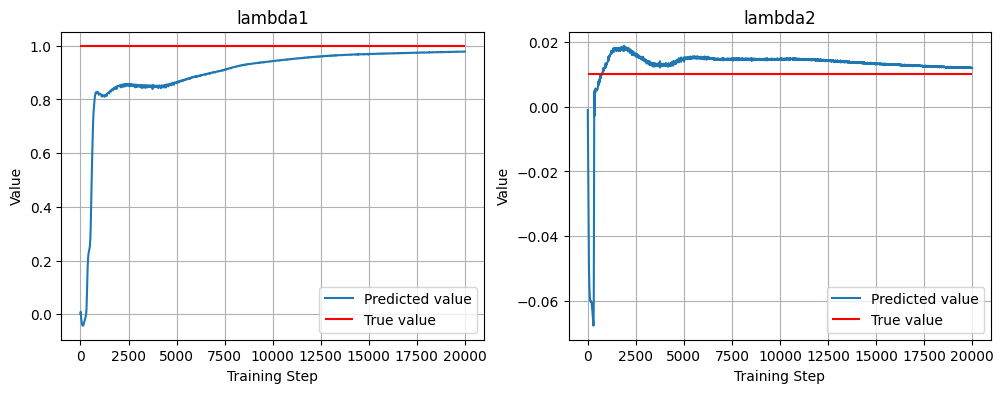

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# lambda1
axes[0].plot(lambda1_values, label="Predicted value")
axes[0].hlines(1, 0, len(lambda1_values), label="True value", colors="red")
axes[0].set_xlabel("Training Step")
axes[0].set_ylabel("Value")
axes[0].set_title("lambda1")
axes[0].legend()
axes[0].grid(True)

# Lambda2
axes[1].plot(lambda2_values, label="Predicted value")
axes[1].hlines(0.01, 0, len(lambda2_values), label="True value", colors="red")
axes[1].set_xlabel("Training Step")
axes[1].set_ylabel("Value")
axes[1].set_title("lambda2")
axes[1].legend()
axes[1].grid(True)

plt.show()